In [1]:
import pandas as pd
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import h5py
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns


WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [2]:
with h5py.File('..\data\Galaxy10_DECals.h5', 'r') as data:
    images = np.array(data['images'])
    labels = np.array(data['ans'])
    



In [3]:
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique, counts))
class_counts

{0: 1081,
 1: 1853,
 2: 2645,
 3: 2027,
 4: 334,
 5: 2043,
 6: 1829,
 7: 2628,
 8: 1423,
 9: 1873}

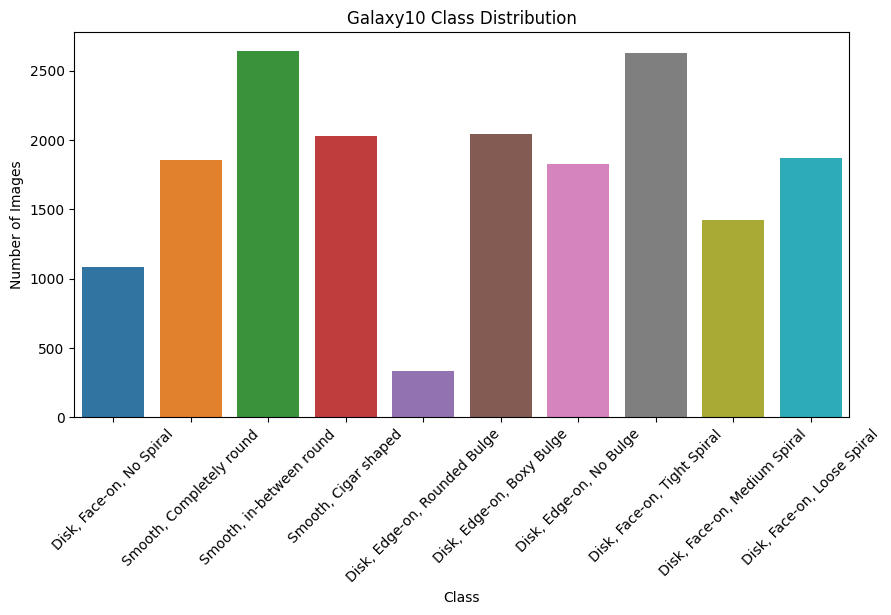

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list([galaxy10cls_lookup(i) for i in class_counts.keys()]), y=counts)
plt.title('Galaxy10 Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.show()

In [5]:
media = class_counts.values()
media = np.mean(list(media))
media

1773.6

In [17]:
from skimage.transform import resize

def resize_convert_savehdf5(images, labels, new_shape=(128, 128, 3), dtype=np.float16):
    resized_images = np.empty((len(images), *new_shape), dtype=dtype)
    for i, img in enumerate(images):
        resized_images[i] = resize(img, new_shape, anti_aliasing=True).astype(dtype)
    
    with h5py.File('..\data\Galaxy10_DECals_resized.h5', 'w') as data:
        data.create_dataset('images', data=resized_images)
        data.create_dataset('ans', data=labels)
    
    



In [18]:
resize_convert_savehdf5(images, labels)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [11]:
def augment_images(images: np.array , labels: np.array, datagen, augment_factor: int):
    augmented_images = []
    augmented_labels = []
    augment_factor = int(augment_factor)
    for i in range(augment_factor):
        random_indice = np.random.randint(0, len(images))
        actual_image = images[random_indice]
        actual_label = labels[random_indice]
        
        image_batch_to_datagen = np.expand_dims(actual_image, axis=0)
        
        augmented_image_iterator = datagen.flow(image_batch_to_datagen, batch_size=1)
        augmented_image = next(augmented_image_iterator)[0]
        augmented_images.append(augmented_image)
        augmented_labels.append(actual_label)
        
    return np.array(augmented_images), np.array(augmented_labels)

In [12]:
def augment_data(class_dict: dict, images: np.array, datagen, labels: np.array):
    
    media = np.mean(list(class_dict.values()))
    media = media.round()
    
    for item in class_dict:
        
        if class_dict[item] < media:
            num_images_augment = media - class_dict[item]
            aug_i, aug_l = augment_images(images, labels, datagen, num_images_augment)
            
            images = np.concatenate((images, aug_i))
            labels = np.concatenate((labels, aug_l))
            
        else:
            #Decrease the number of images of that class 'item'
            num_images_to_remove = class_dict[item] - media
            indices = np.where(labels == item)[0]
            indices_to_remove = np.random.choice(indices, size=int(num_images_to_remove), replace=False)
            images = np.delete(images, indices_to_remove, axis=0)
            labels = np.delete(labels, indices_to_remove, axis=0)
            
            
            
            
            
            
            
    #save in hdf5 file
    with h5py.File('..\data\Galaxy10_DECals_augmented.h5', 'w') as data:
        data.create_dataset('images', data=images)
        data.create_dataset('ans', data=labels)

In [19]:
with h5py.File('..\data\Galaxy10_DECals_resized.h5', 'r') as data:
    images_resized = np.array(data['images'])
    labels_resized = np.array(data['ans'])

In [20]:
augment_data(class_counts, images_resized, datagen, labels_resized)

In [21]:
with h5py.File('..\data\Galaxy10_DECals_augmented.h5', 'r') as data:
    images_augmented = np.array(data['images'])
    labels_augmented = np.array(data['ans'])
    
unique, counts = np.unique(labels_augmented, return_counts=True)
class_counts = dict(zip(unique, counts))
class_counts

{0: 1239,
 1: 2044,
 2: 2071,
 3: 2025,
 4: 383,
 5: 2072,
 6: 2062,
 7: 2133,
 8: 1639,
 9: 2072}

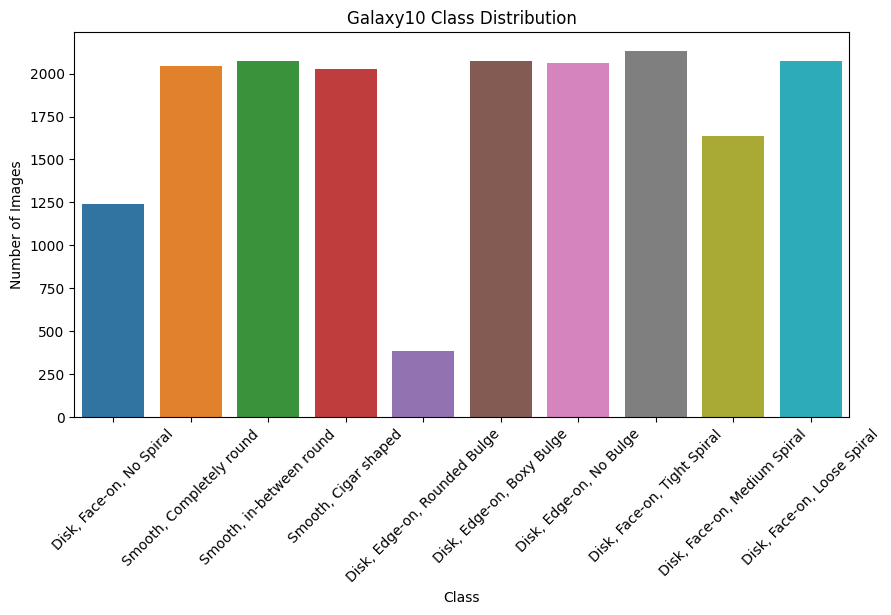

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list([galaxy10cls_lookup(i) for i in class_counts.keys()]), y=counts)
plt.title('Galaxy10 Class Distribution')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.show()